In [62]:
import os
import warnings
import joblib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed 
from sklearn import ensemble, linear_model, svm
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from lazy_test import *
from success_utils import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Create a dictionary to group countries by region
region_groups = {
    "North America": ["HI", "Mexico", "NV", "OK", "NM","CA", "NY", "MD", "DC", "WA", "CO", "MN", "TX", "SC", "GA", "KY", "PA", "MI", "OH", "OR", "NC", "IL", "AZ", "TN", "NJ", "UT", "VA", "ND", "VT", "IA", "ND", "VT", "LA", "CT", "RI"],
    "Europe": ["Martinique", "AL", "Cayman Islands", "Russia", "ME", "UK", "DE", "Poland", "Denmark", "Netherlands", "Norway", "Liechtenstein", "Austria", "Belgium", "Czech Republic", "Iceland", "Ireland", "France", "Spain", "Sweden", "Switzerland", "Italy", "Slovenia", "Greece"],
    "Asia": ["MO", "IN", "Japan", "China", "Hong Kong", "India", "Viet Nam", "Taiwan", "Afghanistan", "Israel","Sri Lanka", "Jordan"],
    "South America": ["Colombia", "Brazil"],
    "Africa": ["WI", "SD", "MA", "Ghana", "Ethiopia", "Liberia", "Rwanda"],
    "Oceania": ["AU", "NZ"],
    "Other": [ "United Arab Emirates", "Svalbard and Jan Mayen"]
}

noticable_entities = ['ORG', 'PERSON', 'DATE',
                        'CARDINAL', 'GPE', 'PRODUCT', 
                        'WORK_OF_ART','ORDINAL', 'MONEY',
                        'TIME', 'NORP']


data_path = '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/Kickstarter_only/final_data.csv'
success_data = pd.read_csv(data_path)
success_data['collection_ratio'] = success_data.collected.apply(decode_amount)/success_data.goal_amount.apply(decode_amount)


bins = [0, 7, 14, 30, 60]
labels = ['<1 week', '1-2 weeks', '2 weeks - 1 month', '1-2 months']
success_data['duration'] = pd.cut(success_data['duration'], bins=bins, labels=labels)
success_data= success_data[success_data.donate != 1].reset_index(drop=True)


success_weights = (1-success_data.success.value_counts()/len(success_data)).values


def get_region(country):
    for region, countries in region_groups.items():
        if country in countries:
            return region
    return "Other"

success_data['region'] = success_data.country.str.strip().apply(get_region)
success_data.num_backers = success_data.num_backers.str.replace(',', '').astype(int)
success_data = success_data[success_data.region == 'North America']

success_data = pd.get_dummies(
                    success_data,
                    columns=['fb_type', 
                              'duration'])


for entity in noticable_entities:
    success_data[f'fb_entity_{entity}'] = success_data.fb_entities_identified.fillna('None').str.split(',').apply(lambda entity_list: entity in entity_list).astype(int)
    

bool_cols = success_data.dtypes[success_data.dtypes == 'bool'].index.tolist()
success_data[bool_cols] = success_data[bool_cols].astype(int)

#ecoding the number of backers
success_data.num_backers = encode_targets(success_data.num_backers)
success_data.population = np.exp(success_data.population)


success_data.head()

,collected,goal_amount,num_backers,category,pledge_types,donate,project_we_love,success,start_month,start_day,population,country,Person,Team,num_projects,num_backed,verified,fb_page_name,fb_likes_at_posting,fb_followers_at_posting,fb_likes,fb_comments,fb_shares,fb_post_views,fb_readability,fb_readability_lix,fb_entropy_scores,fb_perplexity_scores,fb_fear,fb_anger,fb_anticip,fb_trust,fb_surprise,fb_positive,fb_negative,fb_sadness,fb_disgust,fb_joy,fb_entities_identified,fb_post_sponsored,fb_post_age,fb_page_age,fb_positive_reactions,fb_negative_reactions,fb_topic_0,fb_topic_1,fb_topic_2,fb_topic_3,fb_topic_4,fb_topic_5,fb_topic_6,fb_topic_7,fb_topic_8,fb_topic_9,fb_topic_10,collection_ratio,region,fb_type_link,fb_type_photo,fb_type_video,duration_<1 week,duration_1-2 weeks,duration_2 weeks - 1 month,duration_1-2 months,fb_entity_ORG,fb_entity_PERSON,fb_entity_DATE,fb_entity_CARDINAL,fb_entity_GPE,fb_entity_PRODUCT,fb_entity_WORK_OF_ART,fb_entity_ORDINAL,fb_entity_MONEY,fb_entity_TIME,fb_entity_NORP
2,12.960635,10.819778,6.823286,design,4.0,0.0,1.0,1,6,1,684451.0,WA,0,1,7,16,Marc Barros,Kickstarter,1589901,1588019,10,2,1,12,4.836818,33.727273,0.719996,2.054425,0.000024,0.000011,0.000037,0.000062,0.000093,1.000000,0.000029,0.000020,0.000028,0.000062,PRODUCT,0,2,4839,2,0,0.000064,0.000036,0.000074,0.242741,0.000100,0.000050,0.450027,0.075764,0.085070,0.000038,0.116083,8.506720,North America,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
4,11.866416,9.903488,6.954639,comics,8.0,0.0,1.0,1,6,1,105319.0,CA,1,0,3,88,Adam Lawson,Kickstarter,1589930,1588019,4,1,0,5,6.933333,29.111111,0.625279,1.868768,0.000057,0.000018,0.000070,0.000098,0.000096,0.000032,0.000036,0.000013,0.000020,0.000074,"CARDINAL,PERSON",0,8,4839,0,1,0.000026,0.000060,0.939369,0.000080,0.000065,0.000032,0.000011,0.000050,0.000082,0.000096,0.000015,7.120150,North America,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0
5,10.374272,10.308953,5.318120,film_Video,13.0,0.0,1.0,1,6,1,8175133.0,NY,1,0,1,2,Julia Greenberg,Kickstarter,1589715,1587803,3,1,0,4,15.900000,61.666667,0.284582,1.329206,0.285714,0.000047,0.000050,0.000100,0.000088,0.285714,0.142857,0.000096,0.000082,0.142857,"PERSON,GPE",0,9,4839,0,1,0.000019,0.154496,0.000084,0.081168,0.000079,0.126198,0.000052,0.156902,0.294644,0.163853,0.000095,1.067500,North America,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0
6,9.542446,8.804775,5.556828,comics,16.0,0.0,1.0,1,6,1,3971883.0,CA,0,1,4,23,Donold Wooldridge,Kickstarter,1589715,1587803,3,5,1,5,14.239500,45.000000,0.570874,1.769813,0.200000,0.200000,0.000072,0.000028,0.000076,0.000049,0.400000,0.200000,0.000072,0.000036,WORK_OF_ART,0,10,4839,1,1,0.000043,0.000028,0.162778,0.000097,0.000045,0.000027,0.059113,0.062181,0.060710,0.626484,0.000060,2.091059,North America,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
8,11.346304,9.210340,7.051856,games,27.0,0.0,1.0,1,6,4,621849.0,MD,1,0,5,21,Amanda Coronado,Kickstarter,1589543,1587618,9,3,1,11,3.083867,20.333333,0.466686,1.594701,0.000036,0.000051,0.000068,0.000010,0.000083,1.000000,0.000015,0.000030,0.000068,0.000067,"PERSON,CARDINAL",0,14,4839,1,1,0.000018,0.000018,0.073925,0.798958,0.000098,0.000041,0.000093,0.000046,0.000022,0.000042,0.102862,8.465200,North America,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0


In [63]:
dropping_columns = ['collected', 'verified', 'donate', 'project_we_love', 'Team' ,'country', 'fb_page_name', 'region', 'fb_entities_identified', 'population', 'category']

success_data.drop(columns=dropping_columns, axis=1, inplace=True)
success_data = success_data[success_data.collection_ratio < 10].reset_index(drop=True)
success_data.pledge_types = success_data.pledge_types.astype(int)
success_data.num_projects = success_data.num_projects.astype(int)
success_data.num_backed = success_data.num_backed.astype(int)


In [64]:
#identify and list all the boolean features disguised as int in the dataset
bool_features = []
for col in success_data.columns:
    if success_data[col].nunique() == 2:
        bool_features.append(col)

bool_features.remove('success')

In [65]:
entity_features = [x for x in bool_features if 'fb_entity' in x]
duration_features = [x for x in bool_features if 'duration' in x]
region_features = [x for x in bool_features if 'region' in x]


In [66]:
# success_data.num_backers = np.exp(success_data.num_backers)
target_cols = [
    'success',
    'collection_ratio',
    'num_backers'
]

#adding emotionality score
emotion_cols = ['fb_fear','fb_anger', 'fb_anticip', 'fb_trust', 'fb_surprise', 'fb_positive', 'fb_negative', 'fb_sadness', 'fb_disgust', 'fb_joy']
success_data['fb_emotionality'] = success_data[emotion_cols].sum(axis=1)

fb_cols = success_data.columns[success_data.columns.str.startswith('fb')].tolist()
common_features= success_data.columns[~success_data.columns.str.startswith('fb')].tolist()
common_features = [feature for feature in common_features if feature not in target_cols]
common_features.remove("pledge_types")

engagement_features = [ 'fb_likes', 'fb_comments', 'fb_shares','fb_positive_reactions','fb_negative_reactions']
post_fb_features = [feature for feature in fb_cols if feature not in engagement_features]


In [67]:
domain_page_features = success_data[common_features]
domain_engagement_features = success_data[common_features + engagement_features]
domain_post_features = success_data[common_features + post_fb_features]

targets = success_data[target_cols]

In [68]:
pd.concat([domain_page_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_only.csv', index=False)
pd.concat([domain_engagement_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_engagement.csv', index=False)
pd.concat([domain_post_features, targets], axis=1).to_csv('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/domain_post.csv', index=False)

In [69]:
print(common_features)

['goal_amount', 'start_month', 'start_day', 'Person', 'num_projects', 'num_backed', 'duration_<1 week', 'duration_1-2 weeks', 'duration_2 weeks - 1 month', 'duration_1-2 months']


## Modelling

In [70]:
working_data = 'domain_post'
domain_post = pd.read_csv(f'/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Data/final_datasets/{working_data}.csv')
domain_post.num_backers = np.exp(domain_post.num_backers)

In [71]:
domain_post.loc[:,target_cols].head()

,success,collection_ratio,num_backers
0,1,8.506720,919.0
1,1,7.120150,1048.0
2,1,1.067500,204.0
3,1,2.091059,259.0
4,1,8.465200,1155.0


In [72]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(domain_post.drop(target_cols, axis=1), domain_post[target_cols], test_size=0.13, random_state=42, stratify=domain_post.success)

X_train = X_train.reset_index(drop=True).values
X_test = X_test.reset_index(drop=True).values
y_train = y_train.reset_index(drop=True).values
y_test = y_test.reset_index(drop=True).values

* y[:, 0] => Success (Boolean)
* y[:,1] => Collection Ratio
* y[:,2] => Number of Backers


In [76]:
reg_test = RegressionModels(X_train, X_test, y_train[:,2], y_test[:,2], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres.to_csv("/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/02 - Domain Post/num_backers/lazy_scores.csv")
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 108.53it/s]

All models were trained successfully.
All models were evaluated successfully.


,Insample RMSE,Insample MAE,Insample R2,Insample EV Score,Outsample RMSE,Outsample MAE,Outsample R2,Outsample EV Score
ExtraTreesRegressor,0.000,0.000,1.000,1.000,2540.141,856.497,0.448,0.448
BaggingRegressor,757.756,288.131,0.871,0.871,2564.292,1013.967,0.437,0.438
RandomForestRegressor,702.901,267.227,0.889,0.889,2620.672,988.164,0.412,0.412
LarsCV,1894.833,917.604,0.191,0.191,2862.903,1169.338,0.298,0.311
RidgeCV,1820.500,871.299,0.254,0.254,2865.179,1205.829,0.297,0.315
Ridge,1808.231,908.761,0.264,0.264,2885.786,1283.301,0.287,0.306
Lasso,1808.132,911.758,0.264,0.264,2887.890,1283.400,0.286,0.305
LassoLars,1808.132,911.758,0.264,0.264,2887.893,1283.411,0.286,0.305
LinearRegression,1803.055,925.019,0.268,0.268,2901.281,1284.194,0.279,0.299
GradientBoostingRegressor,390.374,268.592,0.966,0.966,2902.101,967.330,0.279,0.279


In [77]:
cls_test = ClassificationModels(X_train, X_test, y_train[:,0], y_test[:,0])
cls_test.run_evaluation()
print(cls_test.not_trained_)
print(cls_test.not_evaluated_)
cls_test.top_10_socres.to_csv("/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/02 - Domain Post/success/lazy_scores.csv")
cls_test.top_10_socres

Evaluating models: 100%|██████████| 27/27 [00:00<00:00, 142.53it/s]

The modelsNu-Support Vector Machine could not be trained.
The modelsKernel Ridge could not be evaluated.


,Accuracy,Precision,Recall,F1 Score,ROC AUC,Class-0 Acc,Class-1 Acc
Balanced Random Forest Classifier,0.708333,1.000000,0.676923,0.807339,0.838462,1.000000,0.676923
Easy Ensemble Classifier,0.583333,0.972973,0.553846,0.705882,0.705495,0.857143,0.553846
Balanced Bagging Classifier,0.541667,0.944444,0.523077,0.673267,0.618681,0.714286,0.523077
Gaussian Naive Bayes,0.527778,0.942857,0.507692,0.660000,0.610989,0.714286,0.507692
Gaussian Process,0.152778,0.750000,0.092308,0.164384,0.403297,0.714286,0.092308
Multinomial Naive Bayes,0.625000,0.913043,0.646154,0.756757,0.537363,0.428571,0.646154
RUSBoost Classifier,0.819444,0.919355,0.876923,0.897638,0.581319,0.285714,0.876923
AdaBoost,0.888889,0.913043,0.969231,0.940299,0.556044,0.142857,0.969231
Bagging,0.916667,0.915493,1.000000,0.955882,0.571429,0.142857,1.000000
Support Vector Machine,0.902778,0.902778,1.000000,0.948905,0.500000,0.000000,1.000000


## Further Finetuning of the topk models

### Collection Ratio

In [80]:
reg_test = RegressionModels(X_train, X_test, y_train[:,1], y_test[:,1], decode=False)
reg_test.run_evaluation()
print(reg_test.not_trained_)
print(reg_test.not_evaluated_)
reg_test.top_10_socres.to_csv("/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Results/02 - Domain Post/collection_ratio/lazy_scores.csv")
reg_test.top_10_socres

Evaluating models: 100%|██████████| 40/40 [00:00<00:00, 117.27it/s]


All models were trained successfully.
All models were evaluated successfully.


,Insample RMSE,Insample MAE,Insample R2,Insample EV Score,Outsample RMSE,Outsample MAE,Outsample R2,Outsample EV Score
GradientBoostingRegressor,0.771,0.574,0.850,0.850,1.472,1.046,0.327,0.327
ExtraTreesRegressor,0.000,0.000,1.000,1.000,1.519,1.148,0.284,0.290
BaggingRegressor,0.882,0.543,0.804,0.804,1.572,1.119,0.233,0.234
RandomForestRegressor,0.739,0.505,0.862,0.863,1.602,1.220,0.204,0.206
ElasticNet,1.902,1.298,0.088,0.088,1.661,1.212,0.143,0.144
LassoLarsCV,1.741,1.186,0.236,0.236,1.667,1.246,0.138,0.142
LassoLarsIC,1.741,1.186,0.237,0.237,1.667,1.246,0.138,0.142
RidgeCV,1.732,1.186,0.245,0.245,1.671,1.243,0.134,0.138
LassoLars,1.911,1.311,0.080,0.080,1.687,1.236,0.116,0.117
Lasso,1.911,1.311,0.080,0.080,1.687,1.236,0.116,0.117


In [84]:
elastic_net = linear_model.ElasticNet(random_state=42)
elastic_net.fit(X_train, y_train[:,1])

in_y_pred = elastic_net.predict(X_train)
out_y_pred = elastic_net.predict(X_test)

print(f'In-sample RMSE, R2: {np.sqrt(mean_squared_error(y_train[:,1], in_y_pred)):.2f}, {r2_score(y_train[:,1], in_y_pred)}')
print(f'Out-sample RMSE, R2: {np.sqrt(mean_squared_error(y_test[:,1], out_y_pred)):.2f}, {r2_score(y_test[:,1], out_y_pred)}')

In-sample RMSE, R2: 1.90, 0.08835991746795868
Out-sample RMSE, R2: 1.66, 0.1433332939662818


In [85]:
lars_cv = linear_model.LarsCV(cv=20)
lars_cv.fit(X_train, y_train[:,1])

y_pred_in = lars_cv.predict(X_train)
y_pred_out = lars_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,1], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,1], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,1], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,1], y_pred_out)}')

RMSE In: 1.88
RMSE Out: 1.63
R2 In: 0.10764984292628088
R2 Out: 0.17630059116507335


In [87]:
ridge_cv = linear_model.RidgeCV(cv=20)
ridge_cv.fit(X_train, y_train[:,1])

y_pred_in = ridge_cv.predict(X_train)
y_pred_out = ridge_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,1], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,1], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,1], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,1], y_pred_out)}')

RMSE In: 1.73
RMSE Out: 1.67
R2 In: 0.24471347192052206
R2 Out: 0.13356872757694904


In [88]:
joblib.dump(lars_cv, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl']

### Number of Backers

In [89]:
ridge_cv = linear_model.RidgeCV(cv=10)
ridge_cv.fit(X_train, y_train[:,2])

y_pred_in = ridge_cv.predict(X_train)
y_pred_out = ridge_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In: 1820.50
RMSE Out: 2865.18
R2 In: 0.2535871013802935
R2 Out: 0.29710551995040724


In [90]:
lars_cv = linear_model.LarsCV(cv=10)
lars_cv.fit(X_train, y_train[:,2])

y_pred_in = lars_cv.predict(X_train)
y_pred_out = lars_cv.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In: 2007.00
RMSE Out: 2700.38
R2 In: 0.09281829238841777
R2 Out: 0.37564011996916624


In [92]:
poisson = linear_model.PoissonRegressor()
poisson.fit(X_train, y_train[:,2])

y_pred_in = poisson.predict(X_train)
y_pred_out = poisson.predict(X_test)

print(f'RMSE In: {np.sqrt(mean_squared_error(y_train[:,2], y_pred_in)):.2f}')
print(f'RMSE Out: {np.sqrt(mean_squared_error(y_test[:,2], y_pred_out)):.2f}')

print(f'R2 In: {r2_score(y_train[:,2], y_pred_in)}')
print(f'R2 Out: {r2_score(y_test[:,2], y_pred_out)}')

RMSE In: 2107.18
RMSE Out: 3451.62
R2 In: 1.1102230246251565e-16
R2 Out: -0.020073690541538847


In [93]:
joblib.dump(lars_cv, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl']

> Despite the encoded targets showing very good R2, when decoded, the R2 is not as good. 

Before Decoding: 

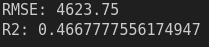

After Decoding:

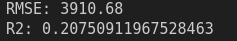

Hence, the best model with un-encoded training, is further finetuned. 

### Success

In [94]:
balanced_bagging = BalancedBaggingClassifier(random_state=42, n_jobs=-1)
balanced_bagging.fit(X_train, y_train[:,0])

y_pred_in = balanced_bagging.predict(X_train)
y_pred_out = balanced_bagging.predict(X_test)

print(f'Accuracy In: {accuracy_score(y_train[:,0], y_pred_in)}')
print(f'Accuracy Out: {accuracy_score(y_test[:,0], y_pred_out)}')

def get_class_wise_acc(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0,0]/cm[0].sum(), cm[1,1]/cm[1].sum()

print(f'Classwise Accuracy In: {get_class_wise_acc(y_train[:,0], y_pred_in)}')
print(f'Classwise Accuracy Out: {get_class_wise_acc(y_test[:,0], y_pred_out)}')


Accuracy In: 0.6457023060796646
Accuracy Out: 0.5416666666666666
Classwise Accuracy In: (1.0, 0.6069767441860465)
Classwise Accuracy Out: (0.7142857142857143, 0.5230769230769231)


In [95]:
easy_ensemble = EasyEnsembleClassifier(random_state=42, n_jobs=-1)
easy_ensemble.fit(X_train, y_train[:,0])

y_pred_in = easy_ensemble.predict(X_train)
y_pred_out = easy_ensemble.predict(X_test)

print(f'Accuracy In: {accuracy_score(y_train[:,0], y_pred_in)}')
print(f'Accuracy Out: {accuracy_score(y_test[:,0], y_pred_out)}')

print(f'Classwise Accuracy In: {get_class_wise_acc(y_train[:,0], y_pred_in)}')
print(f'Classwise Accuracy Out: {get_class_wise_acc(y_test[:,0], y_pred_out)}')


Accuracy In: 0.6477987421383647
Accuracy Out: 0.5833333333333334
Classwise Accuracy In: (1.0, 0.6093023255813953)
Classwise Accuracy Out: (0.8571428571428571, 0.5538461538461539)


In [96]:
joblib.dump(easy_ensemble, '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/success.pkl')

['/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/success.pkl']

## Insample and outof sample tests

In [97]:
num_backers_model =  joblib.load( '/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/num_backers.pkl')
collection_model = joblib.load('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/collection_ratio.pkl')
success_model = joblib.load('/home/theerthala/Documents/repos/Crowdfunding-Social-Media-Drivers/Modelling/final_models/02_domain_post/success.pkl')

In [100]:
#insample scores
print('Insample Scores')
y_pred = num_backers_model.predict(X_train)
print(f'RMSE: {np.sqrt(mean_squared_error(y_train[:,2], y_pred)):.3f}')

y_pred = collection_model.predict(X_train)
print(f'RMSE: {np.sqrt(mean_squared_error(y_train[:,1], y_pred)):.2f}')

y_pred = success_model.predict(X_train)
print(f'Accuracy: {accuracy_score(y_train[:,0], y_pred)}')

print()
#out-of-sample scores
print('Out of Sample')
y_pred = num_backers_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,2], y_pred)):.3f}')

y_pred = collection_model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(y_test[:,1], y_pred)):.2f}')

y_pred = success_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test[:,0], y_pred)}')

Insample Scores
RMSE: 2007.004
RMSE: 1.88
Accuracy: 0.6477987421383647

Out of Sample
RMSE: 2700.375
RMSE: 1.63
Accuracy: 0.5833333333333334


In [101]:
domain_post_features.columns

Index(['goal_amount', 'start_month', 'start_day', 'Person', 'num_projects',
       'num_backed', 'duration_<1 week', 'duration_1-2 weeks',
       'duration_2 weeks - 1 month', 'duration_1-2 months',
       'fb_likes_at_posting', 'fb_followers_at_posting', 'fb_post_views',
       'fb_readability', 'fb_readability_lix', 'fb_entropy_scores',
       'fb_perplexity_scores', 'fb_fear', 'fb_anger', 'fb_anticip', 'fb_trust',
       'fb_surprise', 'fb_positive', 'fb_negative', 'fb_sadness', 'fb_disgust',
       'fb_joy', 'fb_post_sponsored', 'fb_post_age', 'fb_page_age',
       'fb_topic_0', 'fb_topic_1', 'fb_topic_2', 'fb_topic_3', 'fb_topic_4',
       'fb_topic_5', 'fb_topic_6', 'fb_topic_7', 'fb_topic_8', 'fb_topic_9',
       'fb_topic_10', 'fb_type_link', 'fb_type_photo', 'fb_type_video',
       'fb_entity_ORG', 'fb_entity_PERSON', 'fb_entity_DATE',
       'fb_entity_CARDINAL', 'fb_entity_GPE', 'fb_entity_PRODUCT',
       'fb_entity_WORK_OF_ART', 'fb_entity_ORDINAL', 'fb_entity_MONEY',
    